In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# Parameters
# drift coefficent
mu = 0.3
# number of steps
n = 10000
# time in years
T = 1
# number of sims
M = 100
# initial stock price
S0 = 100
# volatility
sigma = 0

# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 14,
    'legend.fontsize': 13,
})


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(11)

def sample_from_rate(rate):
    return random.expovariate(rate)

def simulate_cmc(Q, time, warm_up):
    Q = list(Q)  # In case a matrix is input
    state_space = range(len(Q))  # Index the state space
    time_spent = {s:0 for s in state_space}  # Set up a dictionary to keep track of time
    clock = 0  # Keep track of the clock
    current_state = 0  # First state
    traj = [(current_state, 0)] # trajectory
    while clock < time:
        # Sample the transitions
        sojourn_times = [sample_from_rate(rate) for rate in Q[current_state][:current_state]]
        sojourn_times += [10000000000]  # An infinite sojourn to the same state
        sojourn_times += [sample_from_rate(rate) for rate in Q[current_state][current_state + 1:]]

        # Identify the next state
        next_state = min(state_space, key=lambda x: sojourn_times[x])
        sojourn = sojourn_times[next_state]
        
        clock += sojourn
        traj.append((next_state, clock))
        
        if clock > warm_up:  # Keep track if past warm up time
            time_spent[current_state] += sojourn
        current_state = next_state  # Transition
        
    traj[-1] = (traj[-2][0], time) # Truncate final time

    pi = [time_spent[state] / sum(list(time_spent.values())) for state in state_space]  # Calculate probabilities
    return pi, traj

Q = np.array([[-1, 1],
              [3, -3]]
            )

# Q = np.array([[-2, 1, 1],
#               [1, -2, 1],
#               [.1, .1, -.2]]
#             )/100

# p, traj = simulate_cmc(Q, 1000, 0)
# print(p)
# print(traj)

# x_val = [x[1] for x in traj]
# y_val = [x[0] for x in traj]

# plt.plot(x_val, y_val, drawstyle='steps-post')
# plt.grid(axis='y', color='0.7')
# plt.yticks(list(range(len(Q))))
# plt.xlabel('Time')
# plt.ylabel('State')
# plt.show()

In [3]:
pis = []

for i in range(4,20):
    print(2**i)
    pis.append(simulate_cmc(Q, 2**i, 8)[0])

16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536
131072
262144
524288


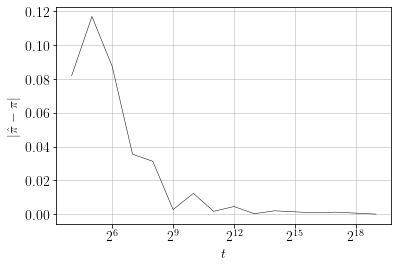

In [4]:
import matplotlib

fig, ax = plt.subplots()
ax.set_xscale('log', base=2)

plt.plot([2**i for i in range(4,20)], [0.5*abs(pi[0]-0.75) + 0.5*abs(pi[1]-0.25) for pi in pis], color='black', lw=0.5)
plt.grid(linewidth=0.5)
# plt.xticks([2**i for i in range])
plt.xlabel(r'$t$')
plt.ylabel(r'$|\hat{\pi} - \pi|$')
plt.show()
# plt.savefig("ctmc_2state.pgf", bbox_inches='tight')

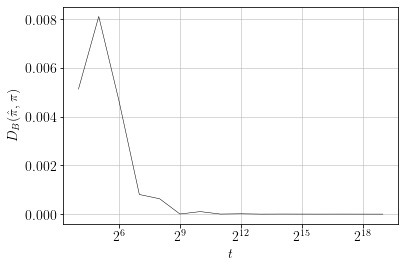

In [5]:
fig, ax = plt.subplots()
ax.set_xscale('log', base=2)

plt.plot([2**i for i in range(4,20)], [-np.log(np.sqrt(pi[0]*0.75) + np.sqrt(pi[1]*0.25)) for pi in pis], color='black', lw=0.5)
plt.grid(linewidth=0.5)
# plt.xticks([2**i for i in range])
plt.xlabel(r'$t$')
plt.ylabel(r'$D_B (\hat{\pi}, \pi)$')
plt.show()
# plt.savefig("ctmc_2state_bhatta.pgf", bbox_inches='tight')

In [6]:
Q = np.array([[-6, 3, 3],
              [4, -12, 8],
              [15, 3, -18]])
            

pis = []

for i in range(4,20):
    print(2**i)
    pis.append(simulate_cmc(Q, 2**i, 8)[0])
    
# print(pis)

16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536
131072
262144
524288


In [7]:
def augment_Q(Q):
    dimension = Q.shape[0]
    M = np.vstack((Q.transpose()[:-1], np.ones(dimension)))
    print(M)
    b = np.vstack((np.zeros((dimension - 1, 1)), [1]))
    print(b)
    return M, b

def obtain_steady_state(Q):
    M, b = augment_Q(Q)
    return np.linalg.solve(M, b).transpose()[0]

expected = obtain_steady_state(Q)

[[ -6.   4.  15.]
 [  3. -12.   3.]
 [  1.   1.   1.]]
[[0.]
 [0.]
 [1.]]


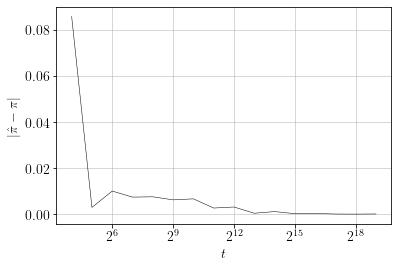

In [8]:
fig, ax = plt.subplots()
ax.set_xscale('log', base=2)

plt.plot([2**i for i in range(4,20)], [abs(pi[0]-expected[0])/3 + abs(pi[1]-expected[1])/3 + abs(pi[2]-expected[2])/3 for pi in pis], color='black', lw=0.5)
plt.grid(linewidth=0.5)
# plt.xticks([2**i for i in range])
plt.xlabel(r'$t$')
plt.ylabel(r'$|\hat{\pi} - \pi|$')
plt.show()
# plt.savefig("ctmc_3state.pgf", bbox_inches='tight')

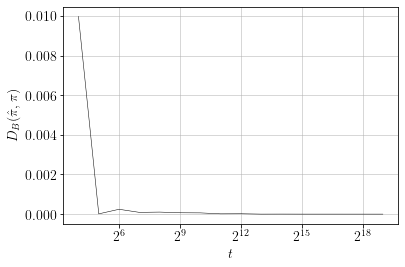

In [9]:
fig, ax = plt.subplots()
ax.set_xscale('log', base=2)
# -np.log(np.sqrt(pi[0]*0.75) + np.sqrt(pi[1]*0.25))
plt.plot([2**i for i in range(4,20)], [-np.log(np.sqrt(pi[0]*expected[0]) + np.sqrt(pi[1]*expected[1]) + np.sqrt(pi[2]*expected[2])) for pi in pis], color='black', lw=0.5)
plt.grid(linewidth=0.5)
# plt.xticks([2**i for i in range])
plt.xlabel(r'$t$')
plt.ylabel(r'$D_B (\hat{\pi}, \pi)$')
plt.show()
# plt.savefig("ctmc_3state_bhatta.pgf", bbox_inches='tight')